In [335]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
class Easy21:

    def __init__(self, max_length=1000):
        self.max_length = max_length

    def reset(self):
        self.player_first_card_val = np.random.choice(10) + 1
        self.dealer_first_card_val = np.random.choice(10) + 1

        self.player_sum = self.player_first_card_val
        self.dealer_sum = self.dealer_first_card_val

        self.state = [self.dealer_first_card_val, self.player_sum]

        self.player_goes_bust = False
        self.dealer_goes_bust = False

        self.ret = 0
        self.terminal = False
        self.t = 0

        return self.state
    
    def check_term(self,state):
        
        return self.terminal
    
    def step(self, action):
        # action 1: hit   0: stick
        # color: 1: black   -1: red
        r = 0

        ### Player hits
        if action == 1 and self.terminal == False:
            self.player_card_val = np.random.choice(10) + 1
            self.player_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

            self.player_sum += (self.player_card_val * self.player_card_col)
            self.player_goes_bust = self.check_go_bust(self.player_sum)
            
            if self.player_goes_bust == 1:
                    r = -1
                    self.terminal = True
            
            self.t+=1
        
        ### Player sticks
        else:
            ##Dealer hits until sum >=17
            while (not self.terminal) and self.dealer_sum < 17 and self.t <= self.max_length:
                self.dealer_card_val = np.random.choice(10) + 1
                self.dealer_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

                self.dealer_sum += (self.dealer_card_val * self.dealer_card_col)
                self.dealer_goes_bust = self.check_go_bust(self.dealer_sum)
            
                ## Dealer goes bust
                if self.dealer_goes_bust == 1:
                    r = 1
                    self.terminal = True
                    break
                    
                self.t+=1
                
            if not self.terminal:
                
                if self.player_sum > self.dealer_sum: 
                    r = 1
                    self.terminal = True
                elif self.player_sum < self.dealer_sum: 
                    r = -1
                    self.terminal = True
                else:  
                    r = 0
                    self.terminal = True

            
        if self.terminal: return 'Terminal', r, self.terminal
        else:
            self.state[1] = self.player_sum
            return self.state, r, self.terminal


    def check_go_bust(self, Sum):
        return bool(Sum > 21 or Sum < 1)

## Monte Carlo Every Visit

In [274]:
## Monte Carlo -- one episode
def monte_carlo_every(Q, Returns, count_state, count_state_action):
    appeared = np.zeros([10, 21, 2], dtype=int)

    actions = []
    rewards = []
    s = env.reset()
    states = [s]
    sumreward = 0
    #state is a [x,y] pair, x: dealers first card, y:player sum
    
    while True:
        action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
        count_state[s[0]-1, s[1]-1] += 1
        epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        actions.append(action)

        s, r, term = env.step(action=action)
        rewards.append(r)
        
#        print("rewards: ",r)
        if term: break
        else: states.append(s)
        
    for t in range(len(states)):
        
        ## ================== change here ================== ##
        
        ####Returns  R(s,a)
        Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] += sum(rewards[t:])
        
        sumreward += Returns[states[t][0]-1,states[t][1]-1,actions[t-1]]
       
        ####count_state_action, N(s,a)

        count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]] += 1 
        
        ####Q(s,a)
        Q[states[t][0]-1,states[t][1]-1,actions[t-1]] = Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] / count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]]
      
        ## ================================================= ##
    
   # print("sum: ", sumreward)
    return Q, Returns, count_state, count_state_action

In [275]:
## Monte Carlo
Q_MCe = np.zeros([10, 21, 2]) # Q(s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

n_episodes = 500000
env = Easy21()

for i_epi in range(n_episodes):
    Q_MCe, Returns, count_state, count_state_action = monte_carlo_every(Q_MCe, Returns, count_state, count_state_action)

V_MCe = Q_MCe.max(axis=2)

# Define SARSA Class

In [35]:
class SARSA_Agent:
    
    def __init__(self, environment, lam, gamma):
        
        self.lam = lam
        self.gamma=1
        self.mse = float('inf')
        self.env = environment; 
        
        #Initialise the state value function to zero
        self.V = np.zeros([10,21])
        
        # Initialize state-action pair to zero
        self.Q = np.zeros([10,21,2])
        
        # N(s,a) is the number of times that action a has been selected from state s.
        self.Nsa = np.zeros([10,21,2]) 
        
        # N(s) is the number of times that
        
        # eligibility trace for every state-action pair
        self.E = np.zeros([10,21,2])
        
        self.episodes = 0
        
    def select_action(self,state):
            epsilon=0.05
            action_greedy = self.Q[state[0]-1,state[1]-1,:].argmax()
            action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
            return action
        
    def train(self,num_episodes,stepsize):
            for episode in range(num_episodes):
                
                #random start
                s = self.env.reset()
                
                
                #generate an episode with the epsilon greedy policy
                a = self.select_action(s)
                
                is_term = self.env.check_term(s)
                
                while not is_term:
                    
                    #update N(s,a)
                    self.Nsa[s[0]-1,s[1]-1,a] +=1
                    
                    #excute action a, observe s_new and r
                    s_new,r,done = self.env.step(a)
                    
                    dealer_id = s[0]-1
                    player_id = s[1]-1
                    
                    if self.env.check_term(s_new)==True:
                        Q_new =0
                        is_term=True
                    else:
                        #select new action, a_new, using policy derived from Q
                        a_new = self.select_action(s_new)
                        
                        dealer_id_new = s[0]-1
                        player_id_new = s[1]-1
                        
                        Q_new = self.Q[dealer_id_new, player_id_new, a_new]
                    
                    #calculate TD error
                    td_error = r + self.gamma*Q_new - self.Q[dealer_id,player_id,a]

                    
                    #Update Eligibility trace
                    self.E[dealer_id,player_id, a] += 1
                    
                     #update the Q and E for all state-action pairs 
                    self.Q += stepsize*td_error*self.E
                    self.E *= self.gamma*self.lam
                    
                    s = s_new
                    if not self.env.check_term(s_new):
                        a = a_new   
                self.episodes = self.episodes + num_episodes     
            
    def update_V(self):
                 for dealer_id in range(10):
                    for player_id in range(21):
                        self.V[dealer_id,player_id] = max(self.Q[dealer_id,player_id,:])
                
                
    def get_Q(self):
        return self.Q

In [214]:
class SARSA:
    
    def __init__(self, environment, gamma):
        
        self.gamma= 1
        self.mse = float('inf')
        self.env = environment; 
        
        #Initialise the state value function to zero
        self.V = np.zeros([10,21])
        
        # Initialize state-action pair to zero
        self.Q = np.zeros([10,21,2])
        
        # N(s,a) is the number of times that action a has been selected from state s.
        self.Nsa = np.zeros([10,21,2]) 
        
        # N(s) is the number of times that
        self.Ns =np.zeros([10,21])
        
        self.episodes = 0
        
    def select_action(self,state):
            epsilon=0.05
            action_greedy = self.Q[state[0]-1,state[1]-1,:].argmax()
            action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
            return action
        
    def train(self,num_episodes,stepsize):
            for episode in range(num_episodes):
                
                #random start
                s = self.env.reset()
                
                #generate an episode with the epsilon greedy policy
                a = self.select_action(s)
                
                is_term = self.env.check_term(s)
                
                while not is_term:
                    
                    #update N(s,a)
                    self.Nsa[s[0]-1,s[1]-1,a] +=1
                    
                    #excute action a, observe s_new and r
                    s_new,r,done = self.env.step(a)
                    
                    dealer_id = s[0]-1
                    player_id = s[1]-1
                    
                    if done:
                        Q_new =0
                    else:
                        #select new action, a_new, using policy derived from Q
                        a_new = self.select_action(s_new)
                        
                        dealer_id_new = s_new[0]-1
                        player_id_new = s_new[1]-1
                        
                        Q_new = self.Q[dealer_id_new, player_id_new, a_new]
                    
                    #update the Q and E for all state-action pairs 
                    self.Q += stepsize*(r + self.gamma*Q_new - self.Q[dealer_id,player_id,a])
                    
                    s = s_new
                    if not self.env.check_term(s_new):
                        a = a_new   
                    
                    is_term = self.env.check_term(s)

                self.episodes = self.episodes + num_episodes     
            
    def update_V(self):
                 for dealer_id in range(10):
                    for player_id in range(21):
                        self.V[dealer_id,player_id] = max(self.Q[dealer_id,player_id,:])
                
                
    def get_Q(self):
        return self.Q

In [217]:
n_episodes = 20000
env = Easy21()

Alpha = np.arange(0,1,0.1)

#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Alpha))

n_state_action = 10*21*2

s_agent = SARSA(env,gamma)

for i_alpha in range(len(Alpha)):
    s_agent.train(n_episodes,i_alpha)
    Q_SARSA = s_agent.get_Q()
    mse_Q_approx[i_alpha] = (np.sum(np.square(Q_SARSA - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in add


The best alpha is: 0.4


In [218]:
print(Q_SARSA )

[[[nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]]

 [[nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan]
  [nan nan

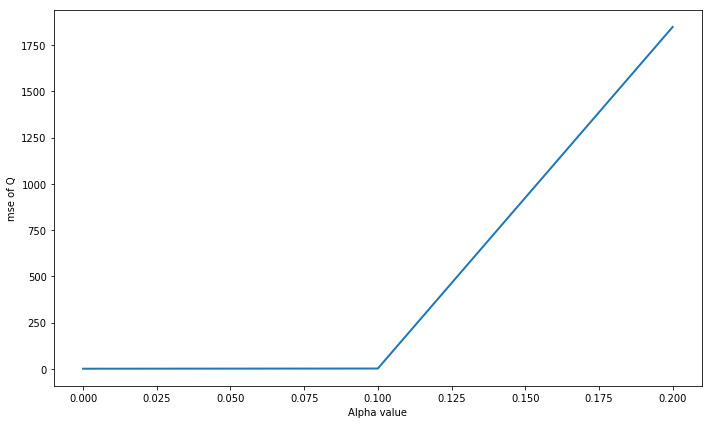

In [219]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()

plt.show()

In [453]:
def SARSA(n_episodes, alpha):
    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])
    # Initialize state-action pair to zero
    
    
    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action

    for episode in range(n_episodes):
        Q = np.zeros([10, 21, 2]) 
        #random start
        s = env.reset()
        a = select_action(s)
        #terminal = env.check_term(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
                   
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break
            else:
                a_new = select_action(s_new)
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                Q_new = Q[dealer_id_new, player_id_new, a_new]               
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
        
    return Q

In [454]:
n_episodes = 200000
env = Easy21()

Alpha = np.arange(0,1,0.05)

#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_SARSA = SARSA(n_episodes,i_alpha) 
    mse_Q_approx[i_alpha] = (np.sum(np.square(Q_SARSA - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

The best alpha is: 0.0


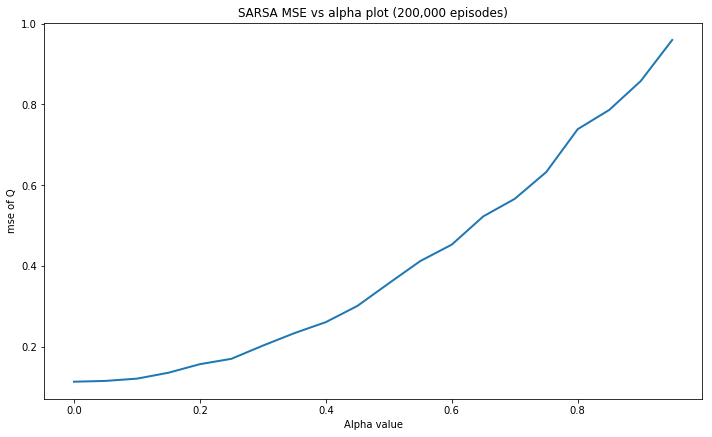

In [455]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('SARSA MSE vs alpha plot (200,000 episodes)')

plt.show()

In [456]:
n_episodes = 400000
env = Easy21()

Alpha = np.arange(0,1,0.1)

#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_SARSA = SARSA(n_episodes,i_alpha) 
    mse_Q_approx[i_alpha] = (np.sum(np.square(Q_SARSA - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

The best alpha is: 0.0


In [ ]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('MSE vs lambda plot (400,000 episodes)')

plt.show()

## Surface plot

In [441]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Sarsa_surf = SARSA(n_episodes, 0.05)
V_Sarsa = Q_Sarsa_surf.max(axis=2)

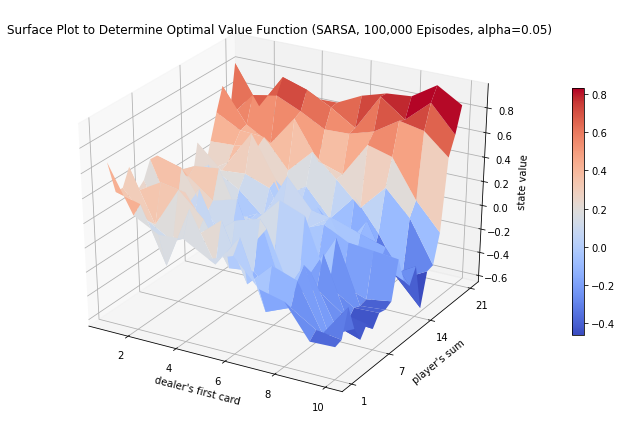

In [442]:
## Sarsa -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Sarsa, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (SARSA, 100,000 Episodes, alpha=0.05)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [429]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Sarsa_surf = SARSA(n_episodes, 0.1)
V_Sarsa = Q_Sarsa_surf.max(axis=2)

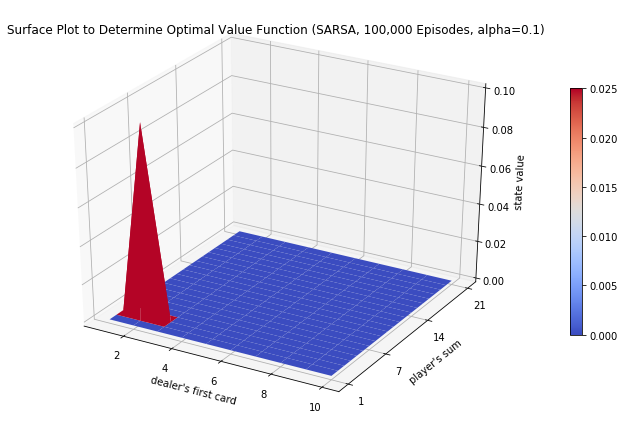

In [430]:
## Sarsa -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Sarsa, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (SARSA, 100,000 Episodes, alpha=0.1)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

## Get mean and standard deviation curves

In [373]:
def SARSA_rewards(n_episodes, alpha):
    appeared = np.zeros([10, 21, 2], dtype=int)
     
    mean_list = []
    sn = 0
    std_list= []
    epi_list =[]
    
    rewards = []
    sumreward = 0    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    
    for episode in range(n_episodes):
         # Initialize state-action pair to zero
        Q = np.zeros([10, 21, 2])

        #random start
        s = env.reset()
        a = select_action(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
            rewards.append(r)       
            sumreward+=r
            
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break       
            
            a_new = select_action(s_new)
            dealer_id_new = s_new[0]-1
            player_id_new = s_new[1]-1
            Q_new = Q[dealer_id_new, player_id_new, a_new]               
            Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
            s = s_new
            a = a_new
        
        """
            for i in range(len(rewards)):    
            if n_episode == 0:
                prev_mean = rewards[i]
                prev_sn = 0
            mean = prev_mean + 1/(n_episode+1)*(rewards[i]-prev_mean)
            sn = prev_sn + ((rewards[i]-prev_mean)*(rewards[i]-mean) - prev_sn)/(n_episode+1)        
            prev_mean = mean
            prev_sn = sn
            std = math.sqrt(sn)
            
        mean_list[n_episode]=mean
        ep_list[n_episode]=n_episode
        std_list[n_episode]=std
           """
        
        
        rewards_length = len(rewards)
        mean = sumreward / rewards_length
        mean_list.append(mean)
        reward_arr = np.array(rewards)
        std = np.std(reward_arr)
        std_list.append(std)
        epi_list.append(episode)
        
    return mean_list, std_list, epi_list


In [374]:
## Plot SARSA rewards against n_episodes
number_episodes = 10000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = SARSA_rewards(number_episodes, 0.3)

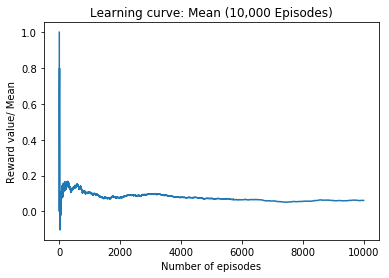

In [375]:
plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Learning curve: Mean (10,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

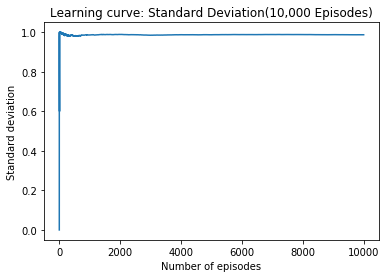

In [376]:
plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard deviation")
plt.title('Learning curve: Standard Deviation(10,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

-----
# Q-learning

In [443]:
def Q_learn(n_episodes, alpha):
    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    Q = np.zeros([10, 21, 2]) 
    
    for episode in range(n_episodes):        

        #random start
        s = env.reset()
        a = select_action(s)
        #terminal = env.check_term(s)
        
        #t =0
        # while t < max_steps:
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
                   
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break
            
            else:
                
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                
                a_new = np.argmax(Q[dealer_id_new,player_id_new,:])
                
                Q_new = Q[dealer_id_new, player_id_new, :].argmax()           
                
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
        
    return Q

In [444]:
n_episodes = 40000
env = Easy21()

Alpha = np.arange(0,1,0.1)

#initalize MSE-Q-approx
mse_Q_approx_ql = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_Qlearn = Q_learn(n_episodes,i_alpha) 
    mse_Q_approx_ql[i_alpha] = (np.sum(np.square(Q_Qlearn - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

KeyboardInterrupt: 

In [ ]:
# Qlearn function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx_ql, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('Q-learning: MSE vs alpha plot (40,000 episodes)')

plt.show()

In [424]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.1)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

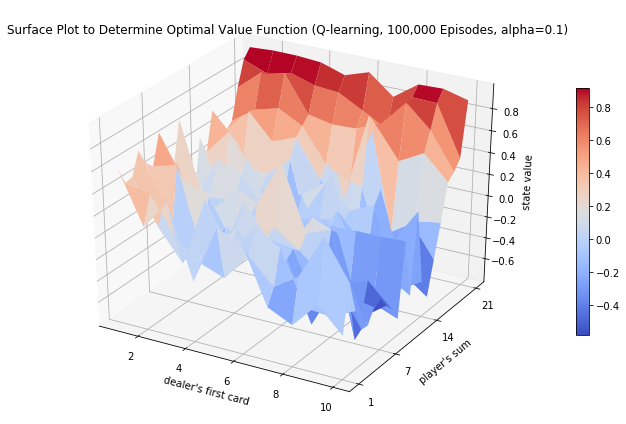

In [426]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.1)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [427]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.3)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

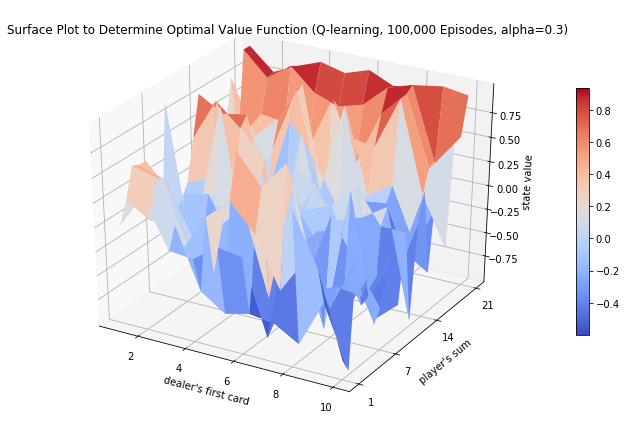

In [428]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.3)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [439]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.05)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

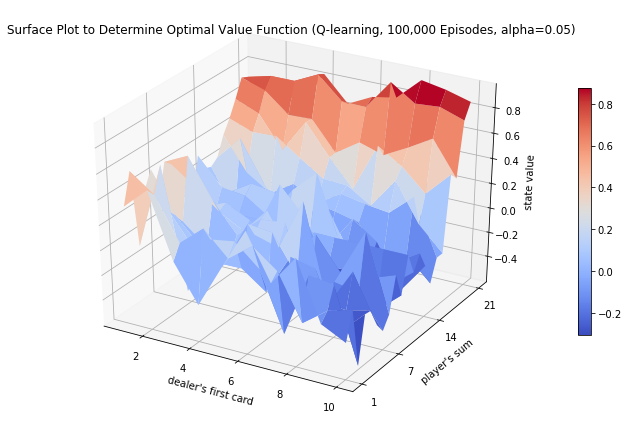

In [440]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.05)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

## Learning curves

In [445]:
def QLearn_rewards(n_episodes, alpha):
    appeared = np.zeros([10, 21, 2], dtype=int)
     
    mean_list = []
    sn = 0
    std_list= []
    epi_list =[]
    
    rewards = []
    sumreward = 0    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    
    for episode in range(n_episodes):
         # Initialize state-action pair to zero
        Q = np.zeros([10, 21, 2])

        #random start
        s = env.reset()
        a = select_action(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
            rewards.append(r)       
            sumreward+=r
            
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break       
            
            

         
            else:
                
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                
                a_new = Q[dealer_id_new,player_id_new,:].argmax()
                
                Q_new = Q[dealer_id_new, player_id_new, a_new]          
                
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
            
        rewards_length = len(rewards)
        mean = sumreward / rewards_length
        mean_list.append(mean)
        reward_arr = np.array(rewards)
        std = np.std(reward_arr)
        std_list.append(std)
        epi_list.append(episode)
        
    return mean_list, std_list, epi_list


### 10,000 episodes, alpha=0.3

In [446]:
## Plot Qlearning rewards against n_episodes

number_episodes = 10000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = QLearn_rewards(number_episodes, 0.3)

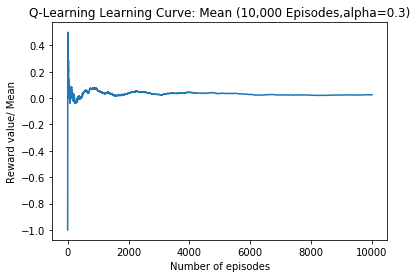

In [449]:
plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (10,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

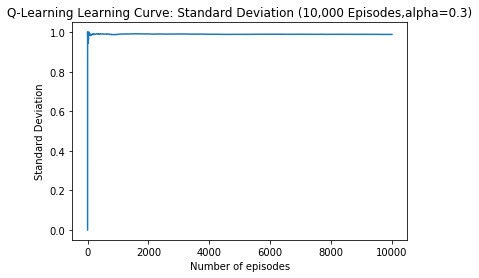

In [450]:
plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (10,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

### 100,000 episodes, alpha=0.3

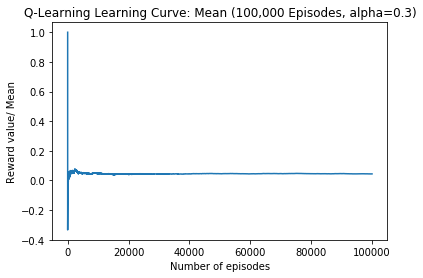

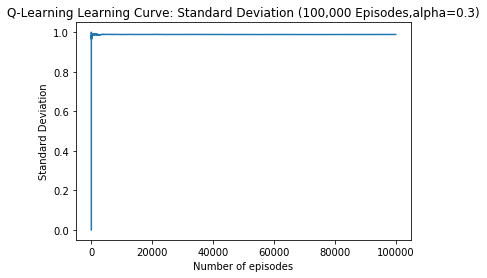

In [451]:
## Plot Qlearning rewards against n_episodes

number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = QLearn_rewards(number_episodes, 0.3)

plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (100,000 Episodes, alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (100,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

### 100,000 episodes, alpha=0.05

In [ ]:

number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = QLearn_rewards(number_episodes, 0.3)

plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (100,000 Episodes, alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (100,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()